In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cvxpy as cp

In [3]:
class ChangeSimulator:
    # Total storage domains
    TOTAL_M = 18
    TOTAL_N = 9528
    DURATION = 345

    def __init__(self):
        # Number of sessions within each domain
        self.Nlist = np.array([3775, 3410, 563 ,551, 457, 300,
            54, 51, 42, 19, 14, 13, 3, 2, 1, 1, 1, 1]) 
        self.Glist = self.Nlist * 1000

    def nothing(self, num_segments):
        self.Glist = self.Nlist * num_segments
        Dlist = (self.Glist - self.Nlist * 2) * np.log(1 + 1/self.Nlist)
        return min(Dlist), sum(Dlist)
                
    def optim(self, num_segments):
        self.TOTAL_C = self.DURATION * num_segments
        # internal gain
        Dlist = (self.Glist - self.Nlist * 2) * np.log(1 + 1/self.Nlist)
        
        # to be solved
        Clist = cp.Variable(self.TOTAL_M, integer=True)

        # Minimum Ji: Objective function 1
        Ji = cp.min(cp.multiply(np.log(1 + self.Nlist), Clist) + Dlist)
        
        # Maximize Minimum Ji
        objective = cp.Maximize(Ji)

        constraints = [
            cp.sum(Clist) <= self.TOTAL_C,
            Clist >= 1]

        problem = cp.Problem(objective, constraints)

        optimal_value = problem.solve()

        epsilon = 0.8 * optimal_value

        # Maximum Jv: Objective function 2
        Clist = cp.Variable(self.TOTAL_M, integer=True)

        Ji = cp.min(cp.multiply(np.log(1 + self.Nlist), Clist) + Dlist)
        J = cp.sum(cp.multiply(np.log(1 + self.Nlist), Clist) + Dlist)

        objective = cp.Maximize(J)

        constraints = [
            Ji >= epsilon,
            cp.sum(Clist) <= self.TOTAL_C,
            Clist >= 1]

        problem = cp.Problem(objective, constraints)

        optimal_value = problem.solve()

        # external gain
        Je_values = Clist.value * np.log(1 + self.Nlist)
        # total gain
        J_values = Je_values + Dlist
        
        return min(J_values), sum(Je_values)

In [4]:
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1.2)
def draw_internal_gain_change():
    simu = ChangeSimulator()
    min_gain_list = []
    internal_gain_list = []
    num_range = range(100, 10100, 1000)
    for num_segments in num_range:
        min_gain, internal_gain = simu.nothing(num_segments)
        min_gain_list.append(min_gain)
        internal_gain_list.append(internal_gain)
    data = np.array([min_gain_list, internal_gain_list]) /1e4
    df = pd.DataFrame(data=data.T, index=num_range, columns=['Vul-domain', 'Internal'])
    ax = sns.lineplot(data=df, markers=True)
    ax.set_xlabel('Number of segments within each domain')
    ax.set_ylabel('Security gain (x1e4)')
    plt.tight_layout()
    plt.savefig('internal_gain_change.png', format='png', bbox_inches='tight', dpi=300)

def draw_external_gain_change():
    simu = ChangeSimulator()
    min_gain_list = []
    external_gain_list = []
    num_range = range(100, 1100, 100)
    for num_segments in num_range:
        min_gain, external_gain = simu.optim(num_segments)
        min_gain_list.append(min_gain)
        external_gain_list.append(external_gain)
    data = np.array([min_gain_list, external_gain_list]) /1e4
    df = pd.DataFrame(data=data.T, index=num_range, columns=['Vul-domain', 'External'])
    ax = sns.lineplot(data=df, markers=True)
    ax.set_xlabel('Number of segments per injection')
    ax.set_ylabel('Security gain (x1e4)')
    plt.tight_layout()
    plt.savefig('external_gain_change.png', format='png', bbox_inches='tight', dpi=300)

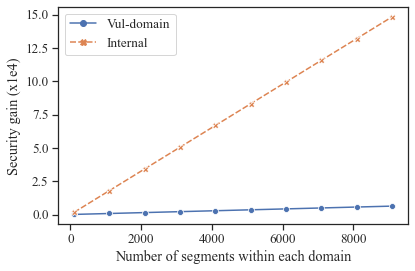

In [5]:
draw_internal_gain_change()


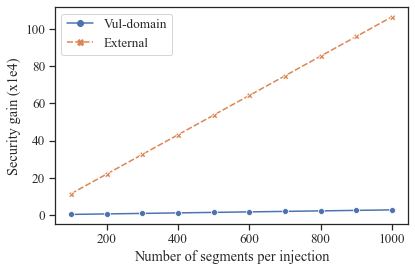

In [6]:
draw_external_gain_change()